# Simulated stellar dynamic spectra analysis

__Andrew Zic__<br>
__5th Chinese SKA Summer School__<br>
__2019-08-15__<br>

In this exercise, we will process and analyse simulated dynamic spectra from an active M-dwarf, UV Ceti, that resembles ASKAP observations of UV Ceti presented in my recent paper. Bursty emission from M-dwarfs at radio frequencies is often very highly polarised, occurs over (relatively) short timescales of seconds to minutes, and can show large amounts of spectral structure as well. Dynamic spectra (showing amplitude as a function of time and frequency) is therefore a fantastic way to obtain detailed information about these bursts.

The dynamic spectra in this exercise are initially given for each instrumental polarisation ($XX$, $YY$, $XY$, and $YX$), and for each baseline of a 16-antenna array (giving $(16\times15)/2 = 120$ baselines).

Prior processing of the data presented here would have included calibration of the visibilities (including bandpass calibration, flux density scaling, complex gain & leakage calibration, and $XY$-phase calibration). The visibilities were inverted and deconvolved, using the deconvolution process to store a model of the field sources around the target star. The sky model constructed during deconvolution is then subtracted from the calibrated visibilities, leaving only the amplitude of the target star remaining in the residual visibilities. The target star was at the phase centre of the observations - if it weren't, then the visibilities would need to be phase-shifted to the location of the target star after calibration and imaging. 

In this tutorial, we will:
- Inspect the data
- Process the data to form dynamic spectra for the four Stokes parameters ($I$, $Q$, $U$, $V$)
- Analyse the features of the dynamic spectra

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import correlate2d, convolve

%matplotlib inline

### Loading the data

The data for each instrumental polarisation are stored in three-dimensional numpy arrays. The dimensions are time, observing frequency, and baseline number. We will use the `np.load` function to load in the numpy arrays.

In [27]:
#time data, in hours
time = np.load('time.npy')

#frequency channel data, in MHz
freq = np.load('freq.npy')

#XX data
XX_baseline = np.load('XX_baselines.npy')

#YY data
YY_baseline = np.load('YY_baselines.npy')

#XY data
XY_baseline = np.load('XY_baselines.npy')

#YX data
YX_baseline = np.load('YX_baselines.npy')

### Inspecting the data

We can examine how many time samples and frequency channels we have for our dynamic spectra by finding the length of the time and frequency arrays:

In [24]:
n_time_samps = len(time) #number of time samples
n_chans = len(freq) #number of frequency channels

print('Number of time samples: {}'.format(n_time_samps))
print('Number of channels: {}'.format(n_chans))

Number of time samples: 1899
Number of channels: 72


#### Exercise:
Determine the duration, time resolution, bandwidth, and spectral resolution of this data.

__Hint__ - to get the first element of the 1-D `time` array, use `time[0]`. The second element is `time[1]`, and so on. To get the last element, you can use `time[len(time)]`, or more conveniently, `time[-1]`.

In [ ]:
#time resolution in hours:

time_res = #complete this line

#duration in hours:

duration = #complete this line

#frequency resolution in MHz:

freq_res = #complete this line

#frequency bandwidth in MHz:

bandwidth = #complete this line

print("""Time resolution: {} hours
Duration: {} hours
Frequency resolution: {} MHz
Bandwidth: {} MHz""".format(time_res, duration, freq_res, bandwidth))

We inspect the data structure and properties below:

In [17]:
print(XX_baseline.shape)

(1899, 72, 120)


So there are 1899 time samples, 72 frequency channels, for 120 baselines.

In the next line, we use the `dtype` attribute to see what type of data we are working with:

In [18]:
XX_baseline.dtype

dtype('complex128')

So we are working with complex-valued data. This makes sense - an interferometer measures the correlations of complex voltages.

As an example, let's plot the $XX$ data from one baseline.

When plotting the dynamic spectra, we transpose it using `np.transpose`, so that we have time on the $x$-axis and frequency on the $y$-axis.

Remember that the visibilities are complex-valued, so we can try plotting the real and imaginary parts separately. For this, we will use `np.real` and `np.imag`.

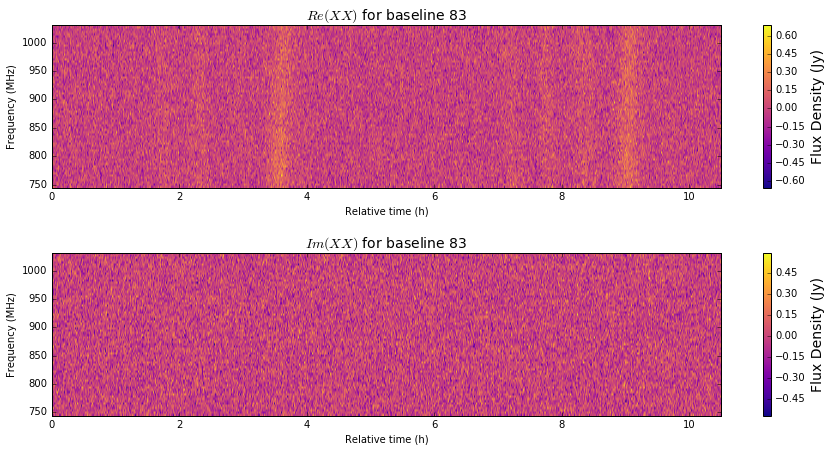

In [37]:
#first, initialise a figure with two subplots:
fig, (ax1, ax2) = plt.subplots(2, #two rows
                               1, #one column
                              figsize = (15, 7))

#choose a baseline number:
baseline = 83

#get the XX dynamic spectrum for this baseline:
XX_test = XX_baseline[:, :, baseline]

#now we plot the real and imaginary parts using pyplot's imshow function
re = ax1.imshow(np.transpose(np.real(XX_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #use an attractive colormap
          )
#create a color-bar and set its label
fig.colorbar(re, ax = ax1).set_label('Flux Density (Jy)', fontsize = 14)


#set the axis labels
ax1.set_xlabel('Relative time (h)')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_title(r'$Re(XX)$ for baseline {}'.format(baseline), fontsize = 14)

im = ax2.imshow(np.transpose(np.imag(XX_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #use an attractive colormap
          )
#create a color-bar and set its label
fig.colorbar(im, ax = ax2).set_label('Flux Density (Jy)', fontsize = 14)

#set the axis labels
ax2.set_xlabel('Relative time (h)')
ax2.set_ylabel('Frequency (MHz)')
ax2.set_title(r'$Im(XX)$ for baseline {}'.format(baseline), fontsize = 14)

fig.subplots_adjust(hspace = 0.4) #adjust subplots so that axis labels and titles don't overlap

So we can see that there appears to be some signal in the real part of $XX$ for this baseline, and the imaginary part appears to contain only noise.

#### Exercise

Copy and paste the code from above into the cell below. Change your code so that it plots the real and imaginary components of the $XY$ instrumental polarisation for one baseline. What do you notice about the real and imaginary components of the $XY$ visibilities compared with the $XX$ visibilities?

You should have noticed that the real part of $XY$ appears to contain only noise, and the imaginary part of $XY$ appears to contain some signal. Why might this be? What does this tell us about the signal we are detecting?

### Revision: measuring the Stokes parameters from instrumental polarisations